In [2]:
import numpy as np
import os
import cv2  # OpenCV for image reading
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import kagglehub as kh

# For reproducibility
random.seed(42)
np.random.seed(42)


2-Download Dataset and Understand Format

In [3]:
path = kh.dataset_download("kasikrit/att-database-of-faces")
print(path)
image_shape = (112, 92)  # (height, width)
n_subjects = 40
n_images_per_subject = 10

/kaggle/input/att-database-of-faces


3- Generate the Data Matrix and the Label Vector

In [4]:
data = []
labels = []

for subject_id in range(1, n_subjects + 1):
    subject_folder = os.path.join(path, f"s{subject_id}")
    for img_name in os.listdir(subject_folder):
        img_path = os.path.join(subject_folder, img_name)

        # Read image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img_flat = img.flatten()  # 112 x 92 = 10304 values
            data.append(img_flat)
            labels.append(subject_id)

# Convert to numpy arrays
D = np.array(data)          # Shape: (400, 10304)
y = np.array(labels)        # Shape: (400,)

print("Data Matrix D shape:", D.shape)
print("Label Vector y shape:", y.shape)

Data Matrix D shape: (400, 10304)
Label Vector y shape: (400,)


4- Split the Dataset into Training and Test sets

In [5]:
# Odd indices (starting from index 0) → Training
train_indices = np.arange(1, D.shape[0], 2)
# Even indices → Testing
test_indices = np.arange(0, D.shape[0], 2)

X_train = D[train_indices]
y_train = y[train_indices]

X_test = D[test_indices]
y_test = y[test_indices]

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Testing Labels Shape:", y_test.shape)

Training Data Shape: (200, 10304)
Training Labels Shape: (200,)
Testing Data Shape: (200, 10304)
Testing Labels Shape: (200,)


5-PCA implementation

In [6]:
class PCA_manual:
    def __init__(self, alpha=0.9):
        self.alpha = alpha
        self.components = None
        self.mean = None
        self.n_components = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Covariance matrix
        cov = np.cov(X_centered, rowvar=False)

        # Eigen decomposition (eigh because cov is symmetric)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Sort eigenvalues and eigenvectors descending
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]  # important: column sort

        # Compute number of components to preserve alpha variance
        total_variance = np.sum(sorted_eigenvalues)
        var_sum = 0.0
        n_components = 0
        for i in range(len(sorted_eigenvalues)):
            var_sum += sorted_eigenvalues[i]
            n_components += 1
            if var_sum / total_variance >= self.alpha:
                break

        self.n_components = n_components
        self.components = sorted_eigenvectors[:, :self.n_components].T

        # Save eigenvalues
        np.save("eigenvalues.npy", sorted_eigenvalues)

        print(f"Selected {self.n_components} components to preserve {self.alpha*100}% variance.")

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)



=== PCA with alpha = 0.8 ===
Selected 36 components to preserve 80.0% variance.
Reduced training data shape: (200, 36)
Reduced testing data shape: (200, 36)


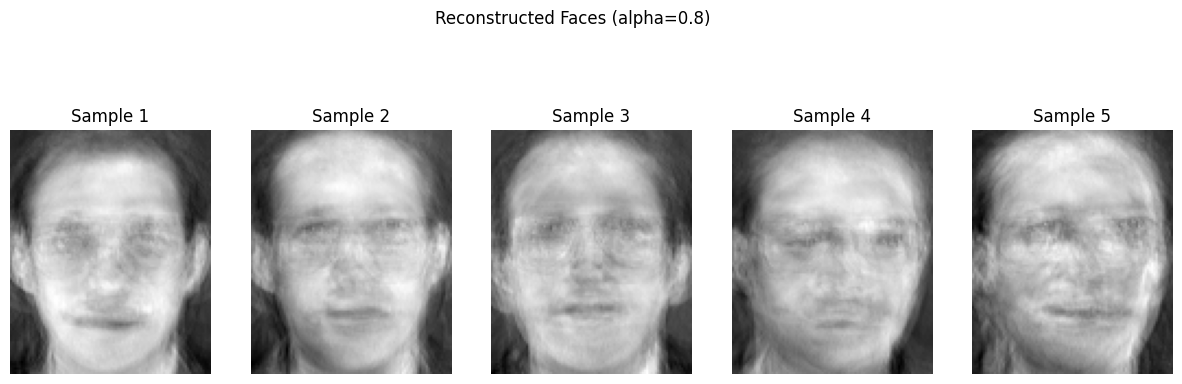


=== PCA with alpha = 0.85 ===
Selected 52 components to preserve 85.0% variance.
Reduced training data shape: (200, 52)
Reduced testing data shape: (200, 52)


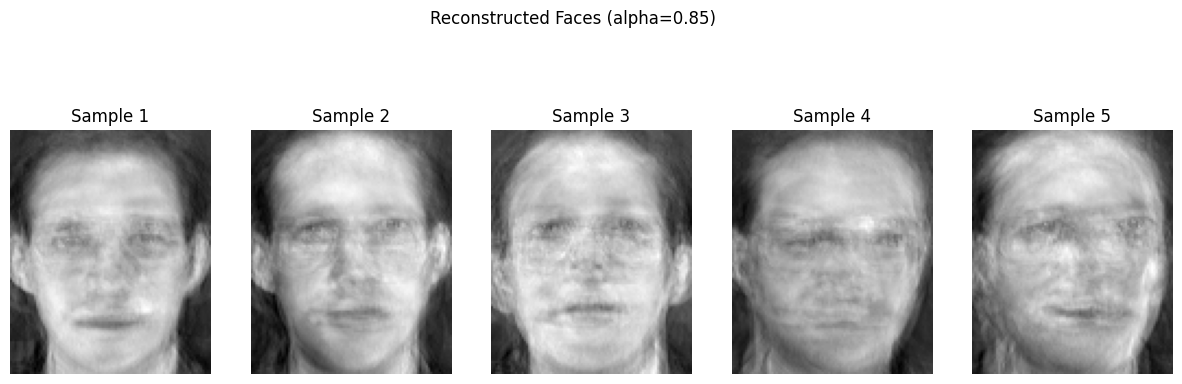


=== PCA with alpha = 0.9 ===
Selected 76 components to preserve 90.0% variance.
Reduced training data shape: (200, 76)
Reduced testing data shape: (200, 76)


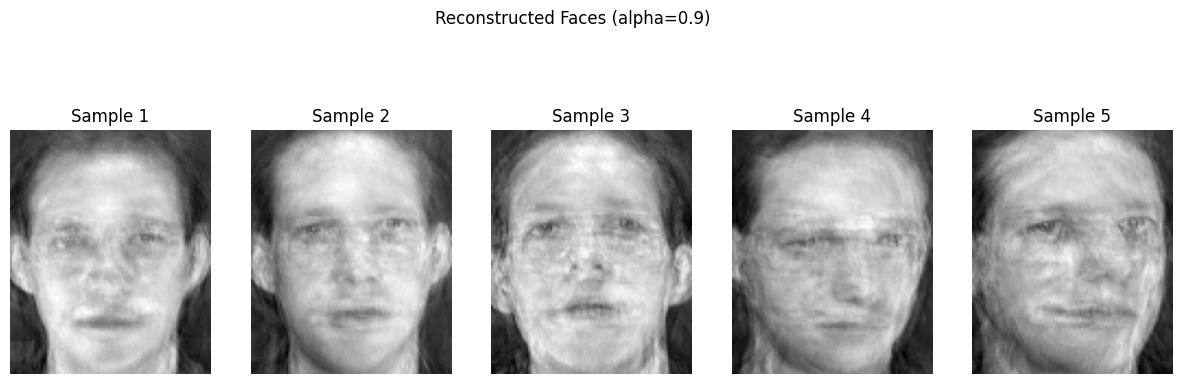


=== PCA with alpha = 0.95 ===
Selected 116 components to preserve 95.0% variance.
Reduced training data shape: (200, 116)
Reduced testing data shape: (200, 116)


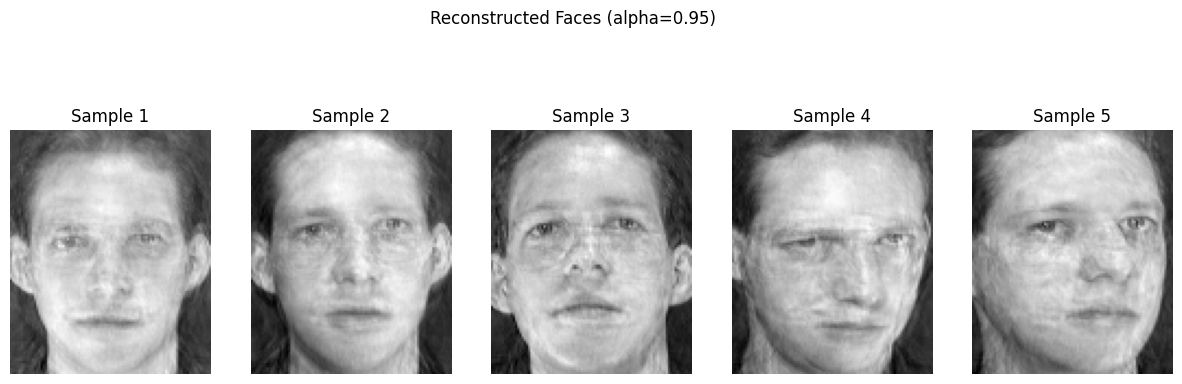

In [7]:
alphas = [0.8, 0.85, 0.9, 0.95]
pca_models = {}
pca_transformed_data = {}
for alpha in alphas:
    print(f"\n=== PCA with alpha = {alpha} ===")

    # Create PCA object
    pca = PCA_manual(alpha=alpha)

    # Fit PCA on training data
    pca.fit(X_train)

    # Transform training and testing data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    pca_models[alpha] = pca
    pca_transformed_data[alpha] = {
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca
    }

    print(f"Reduced training data shape: {X_train_pca.shape}")
    print(f"Reduced testing data shape: {X_test_pca.shape}")

    # Optional: visualize 5 reconstructed faces
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        # Project back to original space
        X_reconstructed = np.dot(X_train_pca[i], pca.components) + pca.mean
        face = X_reconstructed.reshape(image_shape)

        axes[i].imshow(face, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")

    plt.suptitle(f"Reconstructed Faces (alpha={alpha})")
    plt.show()

In [9]:
class KMeans:

    def __init__(self,k,max_iters=100):
        self.k=k
        self.max_iters=max_iters
        self.clusters=[[] for _ in range(k)]
        self.centroids=[]

    def predict(self,X):
        self.X=X
        self.n_samples,self.n_features=X.shape
        # Initialize centroids
        random_indices=np.random.choice(self.n_samples,self.k,replace=False)
        self.centroids=[self.X[i] for i in random_indices]

        # K-means algorithm
        for _ in range(self.max_iters):
            self.clusters=self._create_clusters(self.centroids)
            centroids_old=self.centroids
            self.centroids=self._get_centroids(self.clusters)
            if self._is_converged(centroids_old,self.centroids):
                break

        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self,clusters):
        labels=np.empty(self.n_samples)
        for cluster_idx,cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx]=cluster_idx
        return labels


    def _create_clusters(self,centroids):
        cluster=[[] for _ in range(self.k)]
        for i,x in enumerate(self.X):
            distances=[np.sqrt(np.sum((x-centroid)**2)) for centroid in centroids]
            cluster_idx=np.argmin(distances)
            cluster[cluster_idx].append(i)
        return cluster

    def _get_centroids(self,clusters):
        centroid=[]
        for cluster in clusters:
            centroid.append(np.mean(self.X[cluster],axis=0))
        return centroid
    def _is_converged(self,centroids_old,centroids_new):
        distances=[np.sqrt(np.sum((centroids_old[i]-centroids_new[i])**2)) for i in range(self.k)]
        return sum(distances) == 0



In [14]:
y_train = y_train - 1
print(y_train)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33
 33 33 34 34 34 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38
 38 38 38 39 39 39 39 39]



=== PCA + KMeans Clustering for alpha = 0.8 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.4250

--- Clustering with K = 40 ---
Clustering Accuracy: 0.5650

--- Clustering with K = 60 ---
Clustering Accuracy: 0.6150

=== PCA + KMeans Clustering for alpha = 0.85 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.3850

--- Clustering with K = 40 ---
Clustering Accuracy: 0.5950

--- Clustering with K = 60 ---
Clustering Accuracy: 0.6400

=== PCA + KMeans Clustering for alpha = 0.9 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.4300

--- Clustering with K = 40 ---
Clustering Accuracy: 0.5750

--- Clustering with K = 60 ---
Clustering Accuracy: 0.5700

=== PCA + KMeans Clustering for alpha = 0.95 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.4100

--- Clustering with K = 40 ---
Clustering Accuracy: 0.5900

--- Clustering with K = 60 ---
Clustering Accuracy: 0.6350


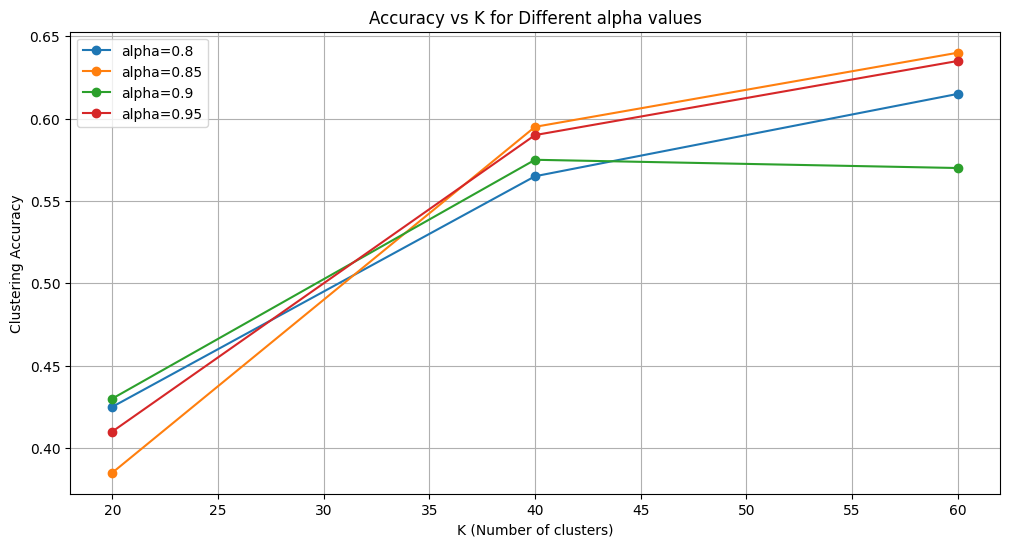

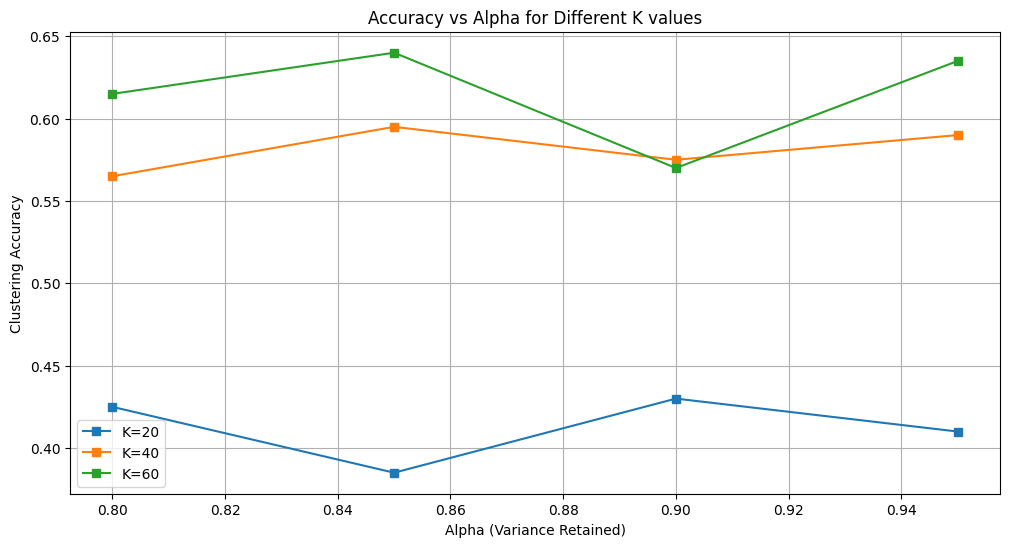

In [25]:
# Define function to compute clustering accuracy
def clustering_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix

    max_labels = max(y_true.max(), y_pred.max()) + 1
    labels = np.arange(max_labels)
    # Build confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = labels)

    max_dim = max(cm.shape)
    padded_cm = np.zeros((max_dim, max_dim))
    padded_cm[:cm.shape[0], :cm.shape[1]] = cm

    # Apply Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-padded_cm)
    accuracy = padded_cm[row_ind, col_ind].sum() / padded_cm.sum()

    return accuracy, row_ind, col_ind
# Set K values
K_values = [20, 40, 60]

# Save accuracies for plotting
results = []
best_acc = 0
best_pca = None
best_kmeans = None
best_alpha = None
best_K = None

# Loop over alpha values
for alpha in alphas:
    print(f"\n=== PCA + KMeans Clustering for alpha = {alpha} ===")

    # Create and fit PCA
    pca = pca_models[alpha]
    # pca = PCA_manual(alpha=alpha)
    # pca.fit(X_train)

    # Reduce dimensions
    X_train_pca = pca_transformed_data[alpha]["X_train_pca"]
    X_test_pca = pca_transformed_data[alpha]["X_test_pca"]

    for K in K_values:
        print(f"\n--- Clustering with K = {K} ---")

        # Create and fit KMeans
        kmeans = KMeans(k=K)
        y_pred = kmeans.predict(X_train_pca)
        y_pred = y_pred.astype(int)
        # Evaluate clustering accuracy
        acc, _, _ = clustering_accuracy(y_train, y_pred)
        print(f"Clustering Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_pca = pca
            best_kmeans = kmeans
            best_alpha = alpha
            best_K = K

        results.append((alpha, K, acc))

# Plot Accuracy vs K for each alpha
import matplotlib.pyplot as plt

# First, plot Accuracy vs K for each alpha
plt.figure(figsize=(12, 6))
for alpha in alphas:
    ks = [k for a, k, acc in results if a == alpha]
    accs = [acc for a, k, acc in results if a == alpha]
    plt.plot(ks, accs, marker='o', label=f'alpha={alpha}')

plt.title('Accuracy vs K for Different alpha values')
plt.xlabel('K (Number of clusters)')
plt.ylabel('Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Second, plot Accuracy vs Alpha for each K
plt.figure(figsize=(12, 6))
for K in K_values:
    alphas_list = [a for a, k, acc in results if k == K]
    accs = [acc for a, k, acc in results if k == K]
    plt.plot(alphas_list, accs, marker='s', label=f'K={K}')

plt.title('Accuracy vs Alpha for Different K values')
plt.xlabel('Alpha (Variance Retained)')
plt.ylabel('Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
y_test = y_test - 1

In [ ]:
Evaluating KMeans Model


Best model: alpha=0.85, K=60, training accuracy=0.6400

Test Clustering Accuracy: 0.6250
F1-Score (Macro): 0.4508
F1-Score (Weighted): 0.6762

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


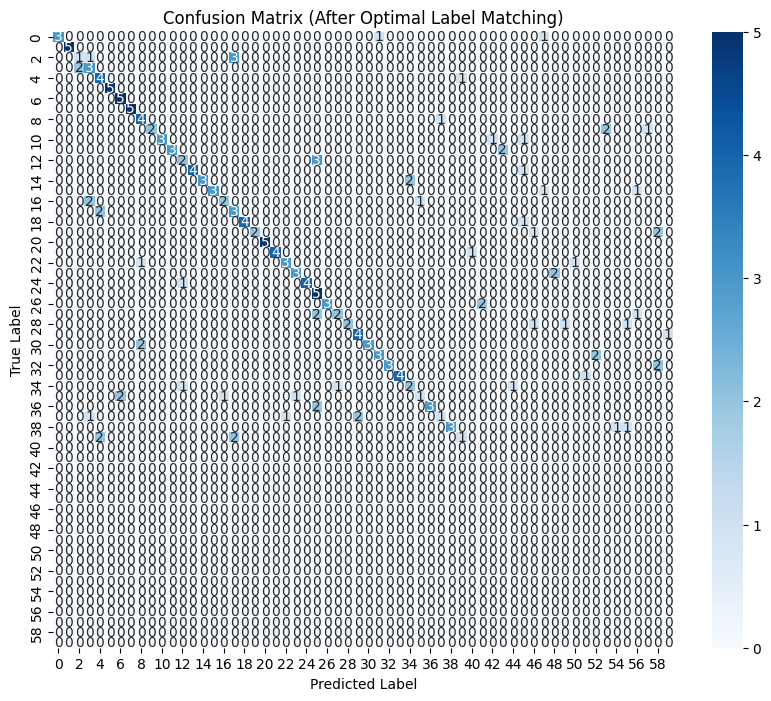

In [28]:
def evaluate_clustering(y_true, y_pred):
    """Comprehensive clustering evaluation with proper label matching"""
    # Calculate clustering accuracy and get optimal mapping
    acc, row_ind, col_ind = clustering_accuracy(y_true, y_pred)

    # Create label mapping dictionary
    label_map = {pred_label: true_label for pred_label, true_label in zip(col_ind, row_ind)}

    # Remap predicted labels to match true labels
    y_pred_mapped = np.array([label_map.get(pred, -1) for pred in y_pred])

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred_mapped, average='macro')
    f1_weighted = f1_score(y_true, y_pred_mapped, average='weighted')
    cm = confusion_matrix(y_true, y_pred_mapped)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'y_pred_mapped': y_pred_mapped
    }


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Print best model
print(f"\nBest model: alpha={best_alpha}, K={best_K}, training accuracy={best_acc:.4f}")

# Apply the same PCA transform on the test data
# X_test_pca = best_pca.transform(X_test)
X_test_pca = pca_transformed_data[best_alpha]["X_test_pca"]



# Predict clusters for test data

y_test_pred = best_kmeans.predict(X_test_pca)
y_test_pred = y_test_pred.astype(int)
results = evaluate_clustering(y_test, y_test_pred)



print(f"\nTest Clustering Accuracy: {results['accuracy']:.4f}")
print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (After Optimal Label Matching)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

b- Gaussian Mixture Model Clustering

In [34]:
import numpy as np

class GMM:
    def __init__(self, k, max_iters=100, tol=1e-3):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        random_indices = np.random.choice(self.n_samples, self.k, replace=False)
        self.means = np.array([self.X[i] for i in random_indices])
        self.covariances = np.array([np.eye(self.n_features) for _ in range(self.k)])  # Original covariance init
        self.weights = np.ones(self.k) / self.k

        log_likelihood_old = None

        for i in range(self.max_iters):
            responsibilities = self._e_step()

            self._m_step(responsibilities)

            log_likelihood_new = self._compute_log_likelihood()

            if log_likelihood_old is not None and abs(log_likelihood_new - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood_new

        return self._get_cluster_labels(responsibilities)

    def _e_step(self):
        responsibilities = np.zeros((self.n_samples, self.k))

        for k in range(self.k):
            # Only change: add tiny constant to covariance before inversion
            safe_cov = self.covariances[k] + 1e-15 * np.eye(self.n_features)
            responsibilities[:, k] = self.weights[k] * self._multivariate_normal(self.X, self.means[k], safe_cov)

        # Only change: add tiny constant before division
        sum_resp = responsibilities.sum(axis=1, keepdims=True) + 1e-300
        responsibilities = responsibilities / sum_resp  # Normalize responsibilities

        return responsibilities

    def _m_step(self, responsibilities):
        N_k = responsibilities.sum(axis=0)

        for k in range(self.k):
            self.means[k] = (1 / N_k[k]) * np.sum(responsibilities[:, k][:, np.newaxis] * self.X, axis=0)
            diff = self.X - self.means[k]
            self.covariances[k] = (1 / N_k[k]) * np.dot((responsibilities[:, k][:, np.newaxis] * diff).T, diff)
            self.weights[k] = N_k[k] / self.n_samples

    def _multivariate_normal(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean
        try:
            # Only change: add handling for problematic determinants
            cov_det = max(np.linalg.det(cov), 1e-300)
            cov_inv = np.linalg.inv(cov)
            exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
            denom = np.sqrt((2 * np.pi) ** n * cov_det)
            return exp_term / denom
        except:
            # Fallback for extreme cases (keeps original behavior but prevents crashes)
            return np.ones(X.shape[0]) * 1e-300

    def _compute_log_likelihood(self):
        likelihood = np.zeros(self.n_samples)
        for k in range(self.k):
            likelihood += self.weights[k] * self._multivariate_normal(self.X, self.means[k], self.covariances[k])
        return np.sum(np.log(likelihood + 1e-300))  # Only change: add tiny constant

    def _get_cluster_labels(self, responsibilities):
        return np.argmax(responsibilities, axis=1)


=== PCA + GMM Clustering for alpha = 0.8 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.0950

--- Clustering with K = 40 ---
Clustering Accuracy: 0.1600

--- Clustering with K = 60 ---
Clustering Accuracy: 0.2000

=== PCA + GMM Clustering for alpha = 0.85 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.1100

--- Clustering with K = 40 ---
Clustering Accuracy: 0.1500

--- Clustering with K = 60 ---
Clustering Accuracy: 0.2050

=== PCA + GMM Clustering for alpha = 0.9 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.0950

--- Clustering with K = 40 ---
Clustering Accuracy: 0.1500

--- Clustering with K = 60 ---
Clustering Accuracy: 0.1850

=== PCA + GMM Clustering for alpha = 0.95 ===

--- Clustering with K = 20 ---
Clustering Accuracy: 0.1100

--- Clustering with K = 40 ---
Clustering Accuracy: 0.1600

--- Clustering with K = 60 ---
Clustering Accuracy: 0.1800


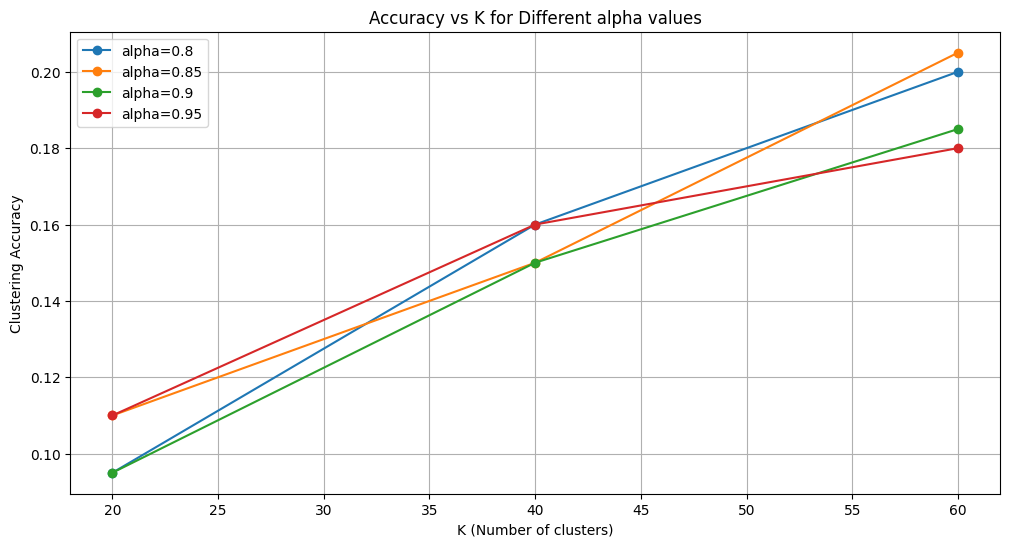

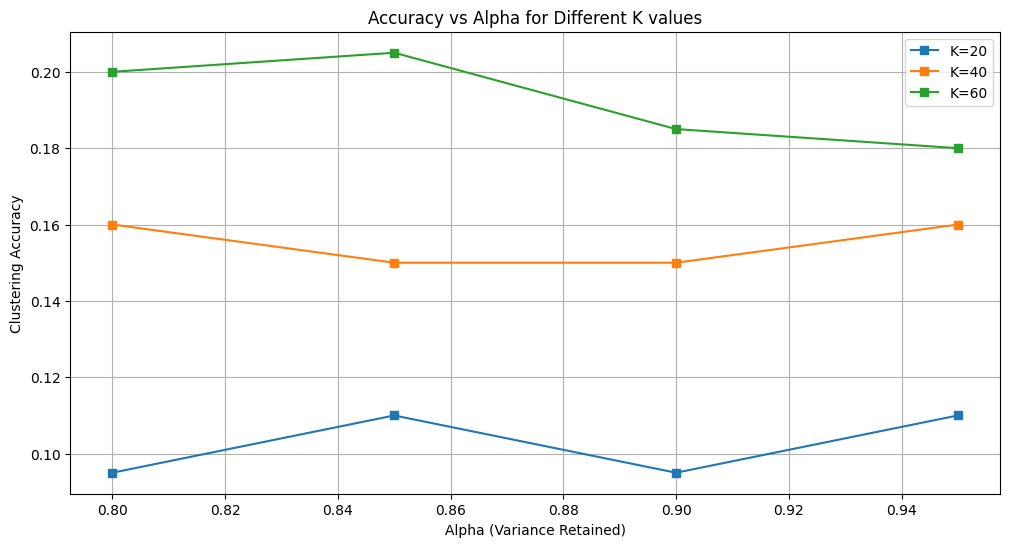

In [38]:
# Define function to compute clustering accuracy
def clustering_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix

    max_labels = max(y_true.max(), y_pred.max()) + 1
    labels = np.arange(max_labels)
    # Build confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    max_dim = max(cm.shape)
    padded_cm = np.zeros((max_dim, max_dim))
    padded_cm[:cm.shape[0], :cm.shape[1]] = cm

    # Apply Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-padded_cm)
    accuracy = padded_cm[row_ind, col_ind].sum() / padded_cm.sum()

    return accuracy, row_ind, col_ind
# Set K values
K_values = [20, 40, 60]

# Save accuracies for plotting
results = []
best_acc = 0
best_pca = None
best_gmm = None
best_alpha = None
best_K = None

# Loop over alpha values
for alpha in alphas:
    print(f"\n=== PCA + GMM Clustering for alpha = {alpha} ===")

    # Create and fit PCA
    pca = pca_models[alpha]
    # pca = PCA_manual(alpha=alpha)
    # pca.fit(X_train)

    # Reduce dimensions
    X_train_pca = pca_transformed_data[alpha]["X_train_pca"]
    X_test_pca = pca_transformed_data[alpha]["X_test_pca"]

    for K in K_values:
        print(f"\n--- Clustering with K = {K} ---")

        # Create and fit gmm
        gmm = GMM(k=K)
        y_pred = gmm.predict(X_train_pca)
        y_pred = y_pred.astype(int)
        # Evaluate clustering accuracy
        acc, _, _ = clustering_accuracy(y_train, y_pred)
        print(f"Clustering Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_pca = pca
            best_gmm = gmm
            best_alpha = alpha
            best_K = K

        results.append((alpha, K, acc))

# Plot Accuracy vs K for each alpha
import matplotlib.pyplot as plt

# First, plot Accuracy vs K for each alpha
plt.figure(figsize=(12, 6))
for alpha in alphas:
    ks = [k for a, k, acc in results if a == alpha]
    accs = [acc for a, k, acc in results if a == alpha]
    plt.plot(ks, accs, marker='o', label=f'alpha={alpha}')

plt.title('Accuracy vs K for Different alpha values')
plt.xlabel('K (Number of clusters)')
plt.ylabel('Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Second, plot Accuracy vs Alpha for each K
plt.figure(figsize=(12, 6))
for K in K_values:
    alphas_list = [a for a, k, acc in results if k == K]
    accs = [acc for a, k, acc in results if k == K]
    plt.plot(alphas_list, accs, marker='s', label=f'K={K}')

plt.title('Accuracy vs Alpha for Different K values')
plt.xlabel('Alpha (Variance Retained)')
plt.ylabel('Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Evaluating GMM Model


Best model: alpha=0.85, K=60, training accuracy=0.2050

Test Clustering Accuracy: 0.2000
F1-Score (Macro): 0.1956
F1-Score (Weighted): 0.2934

Confusion Matrix:
[[1 0 2 ... 0 0 0]
 [0 1 4 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


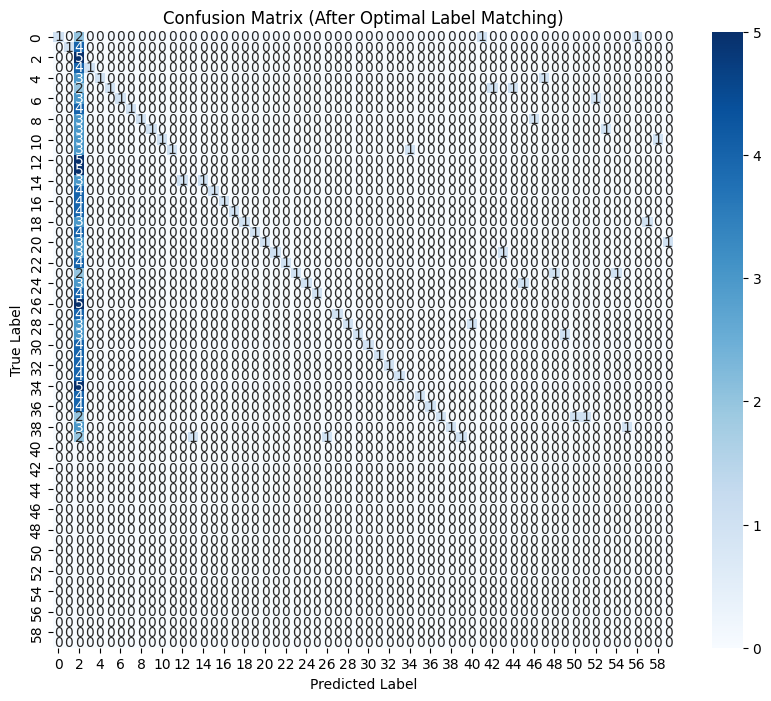

In [39]:
def evaluate_clustering(y_true, y_pred):
    """Comprehensive clustering evaluation with proper label matching"""
    # Calculate clustering accuracy and get optimal mapping
    acc, row_ind, col_ind = clustering_accuracy(y_true, y_pred)

    # Create label mapping dictionary
    label_map = {pred_label: true_label for pred_label, true_label in zip(col_ind, row_ind)}

    # Remap predicted labels to match true labels
    y_pred_mapped = np.array([label_map.get(pred, -1) for pred in y_pred])

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred_mapped, average='macro')
    f1_weighted = f1_score(y_true, y_pred_mapped, average='weighted')
    cm = confusion_matrix(y_true, y_pred_mapped)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'y_pred_mapped': y_pred_mapped
    }


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Print best model
print(f"\nBest model: alpha={best_alpha}, K={best_K}, training accuracy={best_acc:.4f}")

# Apply the same PCA transform on the test data
# X_test_pca = best_pca.transform(X_test)
X_test_pca = pca_transformed_data[best_alpha]["X_test_pca"]



# Predict clusters for test data

y_test_pred = best_gmm.predict(X_test_pca)
y_test_pred = y_test_pred.astype(int)
results = evaluate_clustering(y_test, y_test_pred)



print(f"\nTest Clustering Accuracy: {results['accuracy']:.4f}")
print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (After Optimal Label Matching)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

8. Bonus

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Normalize input
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# Build Autoencoder
encoding_dim = 100  # Latent space size
input_img = layers.Input(shape=(10304,))
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(encoded)
decoded = layers.Dense(10304, activation='sigmoid')(decoded)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_train_norm, X_train_norm, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Get encoded data
X_encoded_train = encoder.predict(X_train_norm)
X_encoded_test = encoder.predict(X_test_norm)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 0.0388 - val_loss: 0.0250
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0232 - val_loss: 0.0244
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0223 - val_loss: 0.0226
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0214 - val_loss: 0.0210
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0186 - val_loss: 0.0187
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0166 - val_loss: 0.0159
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0147 - val_lo

Trying kmean on encoded data


--- Clustering with K = 20 ---
Clustering Accuracy: 0.3750

--- Clustering with K = 40 ---
Clustering Accuracy: 0.5550

--- Clustering with K = 60 ---
Clustering Accuracy: 0.5950


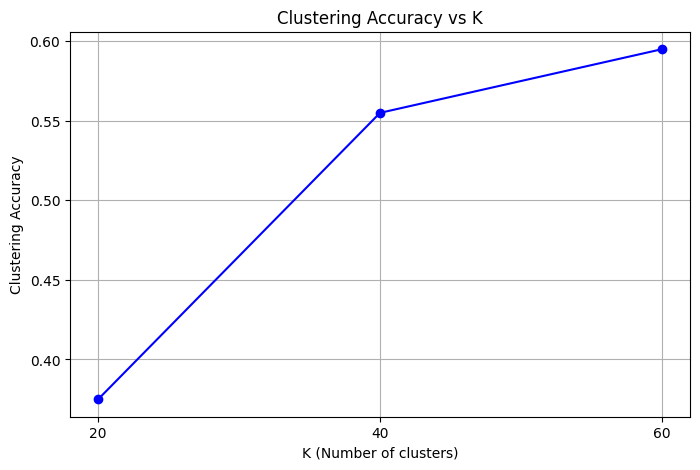

In [42]:
# Define function to compute clustering accuracy
def clustering_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix

    max_labels = max(y_true.max(), y_pred.max()) + 1
    labels = np.arange(max_labels)
    # Build confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = labels)

    max_dim = max(cm.shape)
    padded_cm = np.zeros((max_dim, max_dim))
    padded_cm[:cm.shape[0], :cm.shape[1]] = cm

    # Apply Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-padded_cm)
    accuracy = padded_cm[row_ind, col_ind].sum() / padded_cm.sum()

    return accuracy, row_ind, col_ind
# Set K values
K_values = [20, 40, 60]

# Save accuracies for plotting
results = []
best_acc = 0
best_kmeans = None
best_K = None


for K in K_values:
    print(f"\n--- Clustering with K = {K} ---")
    # Create and fit KMeans
    kmeans = KMeans(k=K)
    y_pred = kmeans.predict(X_encoded_train)
    y_pred = y_pred.astype(int)
    # Evaluate clustering accuracy
    acc, _, _ = clustering_accuracy(y_train, y_pred)
    print(f"Clustering Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_kmeans = kmeans
        best_K = K

    results.append((K, acc))

# Plot Accuracy vs K for each alpha
import matplotlib.pyplot as plt

# Unpack K and accuracy values
ks = [k for k, acc in results]
accs = [acc for k, acc in results]

# Plot Accuracy vs K
plt.figure(figsize=(8, 5))
plt.plot(ks, accs, marker='o', color='b')
plt.title('Clustering Accuracy vs K')
plt.xlabel('K (Number of clusters)')
plt.ylabel('Clustering Accuracy')
plt.xticks(K_values)
plt.grid(True)
plt.show()

then Evaluating on test


Best model:  K=60, training accuracy=0.5950

Test Clustering Accuracy: 0.6100
F1-Score (Macro): 0.4455
F1-Score (Weighted): 0.6683

Confusion Matrix:
[[3 1 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


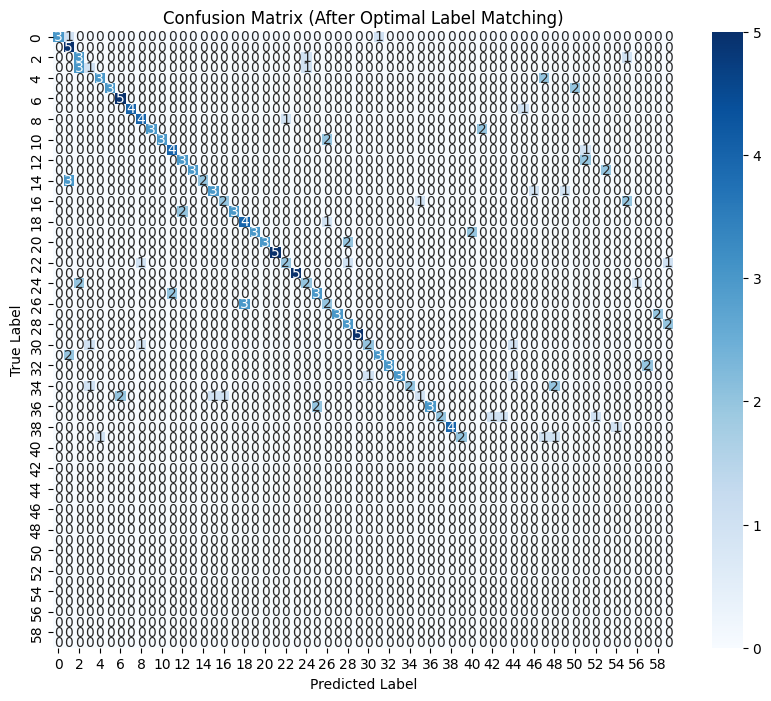

In [43]:
def evaluate_clustering(y_true, y_pred):
    """Comprehensive clustering evaluation with proper label matching"""
    # Calculate clustering accuracy and get optimal mapping
    acc, row_ind, col_ind = clustering_accuracy(y_true, y_pred)

    # Create label mapping dictionary
    label_map = {pred_label: true_label for pred_label, true_label in zip(col_ind, row_ind)}

    # Remap predicted labels to match true labels
    y_pred_mapped = np.array([label_map.get(pred, -1) for pred in y_pred])

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred_mapped, average='macro')
    f1_weighted = f1_score(y_true, y_pred_mapped, average='weighted')
    cm = confusion_matrix(y_true, y_pred_mapped)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'y_pred_mapped': y_pred_mapped
    }


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Print best model
print(f"\nBest model:  K={best_K}, training accuracy={best_acc:.4f}")


y_test_pred = best_kmeans.predict(X_encoded_test)
y_test_pred = y_test_pred.astype(int)
results = evaluate_clustering(y_test, y_test_pred)



print(f"\nTest Clustering Accuracy: {results['accuracy']:.4f}")
print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (After Optimal Label Matching)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [56]:
import numpy as np

class Gmm:
    def __init__(self, k, max_iters=100, tol=1e-3):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        random_indices = np.random.choice(self.n_samples, self.k, replace=False)
        self.means = np.array([self.X[i] for i in random_indices])
        self.covariances = np.array([np.eye(self.n_features) for _ in range(self.k)])
        self.weights = np.ones(self.k) / self.k

        log_likelihood_old = None

        for i in range(self.max_iters):
            responsibilities = self._e_step()
            self._m_step(responsibilities)
            log_likelihood_new = self._compute_log_likelihood()

            if log_likelihood_old is not None and abs(log_likelihood_new - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood_new

        return self._get_cluster_labels(responsibilities)

    def _e_step(self):
        responsibilities = np.zeros((self.n_samples, self.k))
        for k in range(self.k):
            cov = self.covariances[k] + 1e-6 * np.eye(self.n_features)  # Stability
            responsibilities[:, k] = self.weights[k] * self._multivariate_normal(self.X, self.means[k], cov)
        sum_resp = responsibilities.sum(axis=1, keepdims=True) + 1e-10
        responsibilities /= sum_resp
        return responsibilities

    def _m_step(self, responsibilities):
        N_k = responsibilities.sum(axis=0) + 1e-10  # Avoid zero division
        for k in range(self.k):
            weighted_sum = np.sum(responsibilities[:, k][:, np.newaxis] * self.X, axis=0)
            self.means[k] = weighted_sum / N_k[k]
            diff = self.X - self.means[k]
            weighted_cov = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances[k] = weighted_cov / N_k[k] + 1e-6 * np.eye(self.n_features)
            self.weights[k] = N_k[k] / self.n_samples

    def _multivariate_normal(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean
        cov_det = max(np.linalg.det(cov), 1e-12)
        cov_inv = np.linalg.inv(cov)
        # Prevent overflow in exp
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        exponent = np.clip(exponent, -700, 700)  # Prevent overflow
        exp_term = np.exp(exponent)
        denom = np.sqrt((2 * np.pi) ** n * cov_det)
        return exp_term / denom

    def _compute_log_likelihood(self):
        likelihood = np.zeros(self.n_samples)
        for k in range(self.k):
            likelihood += self.weights[k] * self._multivariate_normal(self.X, self.means[k], self.covariances[k])
        return np.sum(np.log(likelihood + 1e-10))

    def _get_cluster_labels(self, responsibilities):
        return np.argmax(responsibilities, axis=1)


then trying GMM on the encoded data


--- Clustering with K = 20 ---
Clustering Accuracy: 0.0250

--- Clustering with K = 40 ---
Clustering Accuracy: 0.0250

--- Clustering with K = 60 ---
Clustering Accuracy: 0.0250


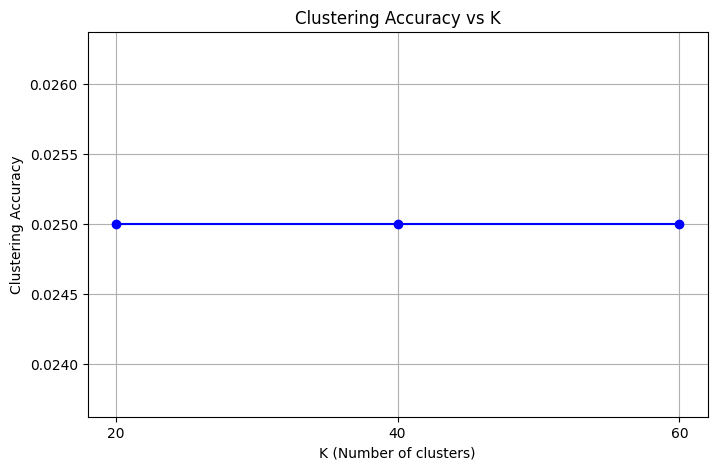

In [63]:
# Define function to compute clustering accuracy
def clustering_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix

    # Relabel y_true and y_pred to ensure consistent indexing
    labels_true = np.unique(y_true)
    labels_pred = np.unique(y_pred)

    # Build confusion matrix without assuming label ranges
    cm = confusion_matrix(y_true, y_pred, labels=labels_true)

    # Apply Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Calculate accuracy from best assignment
    matching = cm[row_ind, col_ind]
    accuracy = matching.sum() / cm.sum()

    return accuracy, row_ind, col_ind

# Set K values
K_values = [20, 40, 60]

# Save accuracies for plotting
results = []
best_acc = 0
best_gmm = None
best_K = None


for K in K_values:
    print(f"\n--- Clustering with K = {K} ---")
    # Create and fit KMeans
    gmm = Gmm(k=K)
    y_pred = gmm.predict(X_encoded_train)
    y_pred = y_pred.astype(int)
    # Evaluate clustering accuracy
    acc, _, _ = clustering_accuracy(y_train, y_pred)
    print(f"Clustering Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_gmm = gmm
        best_K = K

    results.append((K, acc))

# Plot Accuracy vs K for each alpha
import matplotlib.pyplot as plt

# Unpack K and accuracy values
ks = [k for k, acc in results]
accs = [acc for k, acc in results]

# Plot Accuracy vs K
plt.figure(figsize=(8, 5))
plt.plot(ks, accs, marker='o', color='b')
plt.title('Clustering Accuracy vs K')
plt.xlabel('K (Number of clusters)')
plt.ylabel('Clustering Accuracy')
plt.xticks(K_values)
plt.grid(True)
plt.show()

then evaluating on test


Best model:  K=20, training accuracy=0.0250

Test Clustering Accuracy: 0.0250
F1-Score (Macro): 0.0012
F1-Score (Weighted): 0.0012

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]]


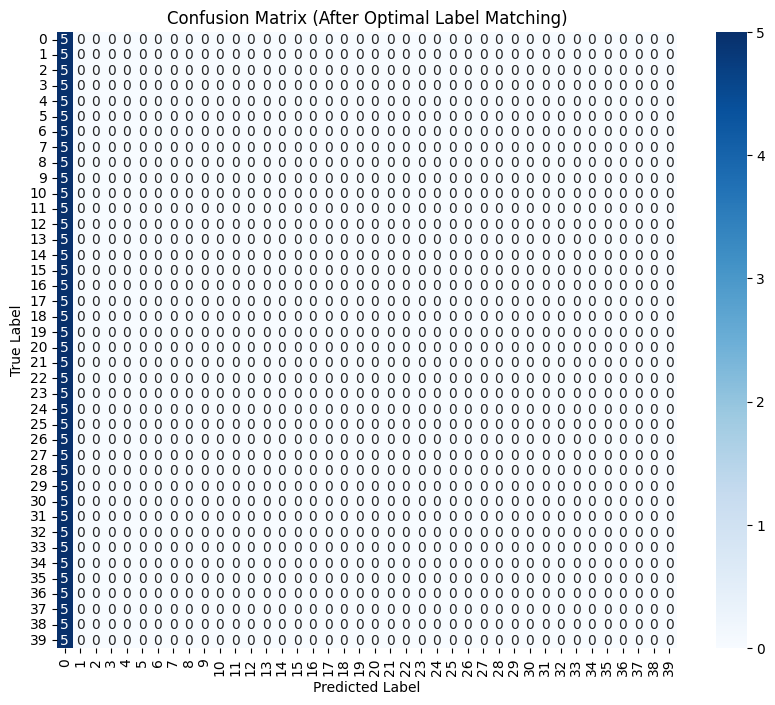

In [60]:
def evaluate_clustering(y_true, y_pred):
    """Comprehensive clustering evaluation with proper label matching"""
    # Calculate clustering accuracy and get optimal mapping
    acc, row_ind, col_ind = clustering_accuracy(y_true, y_pred)

    # Create label mapping dictionary
    label_map = {pred_label: true_label for pred_label, true_label in zip(col_ind, row_ind)}

    # Remap predicted labels to match true labels
    y_pred_mapped = np.array([label_map.get(pred, -1) for pred in y_pred])

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred_mapped, average='macro')
    f1_weighted = f1_score(y_true, y_pred_mapped, average='weighted')
    cm = confusion_matrix(y_true, y_pred_mapped)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'y_pred_mapped': y_pred_mapped
    }


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import seaborn as sns

# Print best model
print(f"\nBest model:  K={best_K}, training accuracy={best_acc:.4f}")


y_test_pred = best_gmm.predict(X_encoded_test)
y_test_pred = y_test_pred.astype(int)
results = evaluate_clustering(y_test, y_test_pred)



print(f"\nTest Clustering Accuracy: {results['accuracy']:.4f}")
print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (After Optimal Label Matching)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()